# Four-Well Potential System: Kernel EDMD + LAWGD

## Objective
1. Define 2D four-well potential system V(x,y) = (x²-1)² + (y²-1)²
2. Compute corresponding Boltzmann stationary distribution π(x) ∝ exp(-V(x))
3. Learn Langevin generator using Kernel EDMD
4. Use LAWGD to transport particles from outside wells into the four potential wells

## Theoretical Background
- Langevin dynamics: dX = -∇V(X)dt + √(2)dW
- Stationary distribution: π(x) ∝ exp(-V(x))
- Four potential wells located at (±1, ±1)
- Goal: Learn generator from data, transport particles to stationary distribution

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd, eig
import time

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## Define Four-Well Potential Function

We define a 2D four-well potential:
$$V(x, y) = (x^2 - 1)^2 + (y^2 - 1)^2$$

This potential has four local minima:
- Well 1: (x, y) ≈ (-1, -1)
- Well 2: (x, y) ≈ (1, -1)
- Well 3: (x, y) ≈ (-1, 1)
- Well 4: (x, y) ≈ (1, 1)
- Central saddle point: (0, 0)

In [2]:
class FourWellPotential:
    """
    2D Four-Well Potential System
    
    Potential function: V(x, y) = a*(x^2 - 1)^2 + b*(y^2 - 1)^2
    
    This creates four potential wells at approximately (±1, ±1)
    
    Parameters:
        a: Controls double-well depth in x-direction (default 1.0)
        b: Controls double-well depth in y-direction (default 1.0)
        temperature: Temperature parameter (default 1.0), affects Boltzmann distribution width
    """
    
    def __init__(self, a=1.0, b=1.0, temperature=1.0):
        self.a = a
        self.b = b
        self.T = temperature  # Temperature (kT in units where k_B = 1)
        self._Z = None  # Partition function cache
        
    def V(self, x, y=None):
        """
        Compute potential energy
        
        Parameters:
            x: If y is None, x is array of shape (n, 2)
               Otherwise x is x-coordinate, y is y-coordinate
        Returns:
            Potential energy value(s)
        """
        if y is None:
            # x is (n, 2) array
            x_coord = x[:, 0] if x.ndim > 1 else x[0]
            y_coord = x[:, 1] if x.ndim > 1 else x[1]
        else:
            x_coord = x
            y_coord = y
            
        return self.a * (x_coord**2 - 1)**2 + self.b * (y_coord**2 - 1)**2
    
    def grad_V(self, X):
        """
        Compute potential gradient ∇V(x, y)
        
        Parameters:
            X: Array of shape (n, 2), each row is a point (x, y)
        Returns:
            Gradient array of shape (n, 2)
        """
        x = X[:, 0]
        y = X[:, 1]
        
        # ∂V/∂x = 4*a*x*(x^2 - 1)
        dV_dx = 4 * self.a * x * (x**2 - 1)
        
        # ∂V/∂y = 4*b*y*(y^2 - 1)
        dV_dy = 4 * self.b * y * (y**2 - 1)
        
        return np.stack([dV_dx, dV_dy], axis=1)
    
    def stationary_density(self, x, y=None, x_range=(-3, 3), y_range=(-3, 3), n_grid=500):
        """
        Compute normalized Boltzmann stationary distribution π(x) = exp(-V(x)/T) / Z
        
        Parameters:
            x, y: Coordinates (can be scalar, array, or grid)
            x_range, y_range: Range for numerical integration to compute Z
            n_grid: Grid size for numerical integration
            
        Returns:
            Normalized density values
        """
        # Compute unnormalized density
        V_val = self.V(x, y)
        unnormalized_density = np.exp(-V_val / self.T)
        
        # Compute partition function Z if not cached
        if self._Z is None:
            x_int = np.linspace(x_range[0], x_range[1], n_grid)
            y_int = np.linspace(y_range[0], y_range[1], n_grid)
            dx = (x_range[1] - x_range[0]) / n_grid
            dy = (y_range[1] - y_range[0]) / n_grid
            X_int, Y_int = np.meshgrid(x_int, y_int)
            V_int = self.V(X_int, Y_int)
            self._Z = np.sum(np.exp(-V_int / self.T)) * dx * dy
        
        return unnormalized_density / self._Z

# Create four-well system instance
potential = FourWellPotential(a=1.0, b=1.0, temperature=0.5)

print("Four-well potential system created!")
print(f"Parameters: a={potential.a}, b={potential.b}, T={potential.T}")
print(f"Energy minima locations: (±1, ±1)")
print(f"Minimum energy value: V(1, 1) = {potential.V(np.array([[1.0, 1.0]]))[0]:.4f}")
print(f"Saddle point value: V(0, 0) = {potential.V(np.array([[0.0, 0.0]]))[0]:.4f}")

Four-well potential system created!
Parameters: a=1.0, b=1.0, T=0.5
Energy minima locations: (±1, ±1)
Minimum energy value: V(1, 1) = 0.0000
Saddle point value: V(0, 0) = 2.0000


## Visualize Potential Landscape and Stationary Distribution

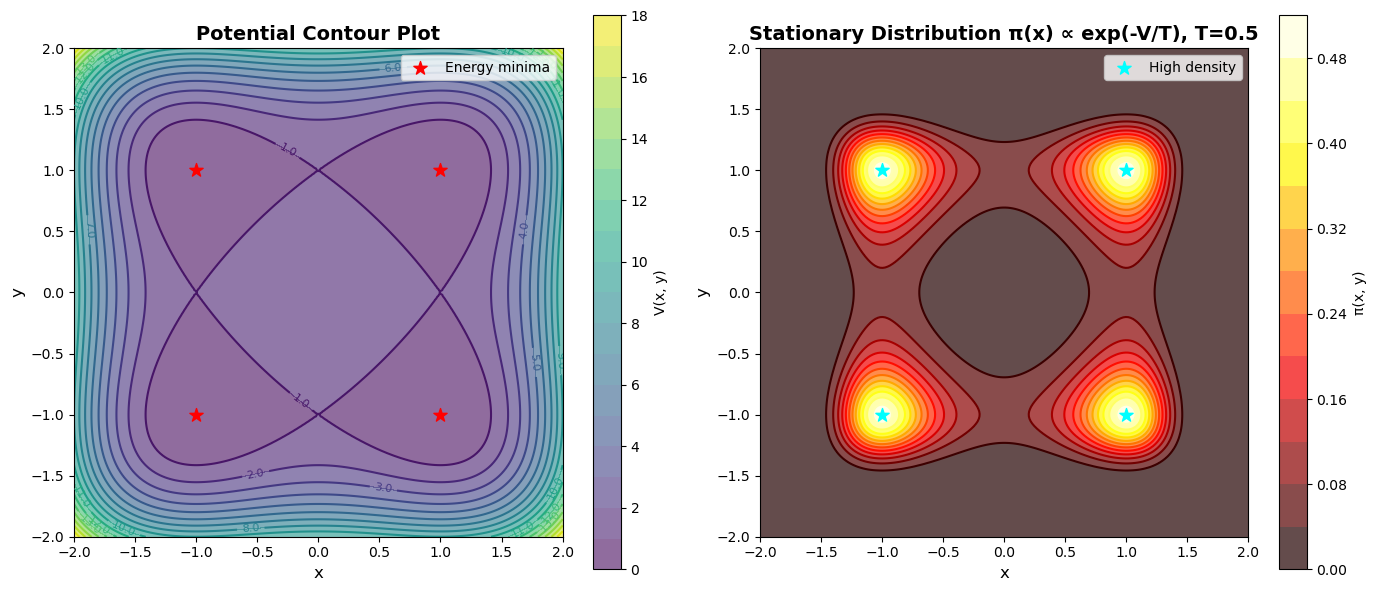


Potential Analysis:
Energy minima: V(±1, ±1) = 0.0000
Central saddle: V(0, 0) = 2.0000
Side saddles: V(±1, 0) = 1.0000
Energy difference: ΔV = 2.0000
Temperature parameter: T = 0.5

Stationary distribution concentrates around four energy minima!


In [3]:
# Create grid for visualization
x_range = np.linspace(-2, 2, 200)
y_range = np.linspace(-2, 2, 200)
X_grid, Y_grid = np.meshgrid(x_range, y_range)

# Compute potential and density
V_grid = potential.V(X_grid, Y_grid)
density_grid = potential.stationary_density(X_grid, Y_grid)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ========== Subplot 1: Potential Contour Plot ==========
ax1 = axes[0]
contour = ax1.contour(X_grid, Y_grid, V_grid, levels=20, cmap='viridis', linewidths=1.5)
contourf = ax1.contourf(X_grid, Y_grid, V_grid, levels=20, cmap='viridis', alpha=0.6)
ax1.clabel(contour, inline=True, fontsize=8, fmt='%.1f')
ax1.scatter([-1, -1, 1, 1], [-1, 1, -1, 1], color='red', s=100, marker='*', 
           label='Energy minima', zorder=10)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_title('Potential Contour Plot', fontsize=14, fontweight='bold')
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_aspect('equal')
ax1.legend(loc='upper right')
fig.colorbar(contourf, ax=ax1, label='V(x, y)')

# ========== Subplot 2: Boltzmann Stationary Distribution π(x) ∝ exp(-V/T) ==========
ax2 = axes[1]
contour_density = ax2.contour(X_grid, Y_grid, density_grid, levels=15, 
                              cmap='hot', linewidths=1.5)
contourf_density = ax2.contourf(X_grid, Y_grid, density_grid, levels=15, 
                                cmap='hot', alpha=0.7)
ax2.scatter([-1, -1, 1, 1], [-1, 1, -1, 1], color='cyan', s=100, marker='*', 
           label='High density', zorder=10)
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('y', fontsize=12)
ax2.set_title(f'Stationary Distribution π(x) ∝ exp(-V/T), T={potential.T}', 
             fontsize=14, fontweight='bold')
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_aspect('equal')
ax2.legend(loc='upper right')
fig.colorbar(contourf_density, ax=ax2, label='π(x, y)')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Potential Analysis:")
print("="*60)
print(f"Energy minima: V(±1, ±1) = {potential.V(np.array([[1.0, 1.0]]))[0]:.4f}")
print(f"Central saddle: V(0, 0) = {potential.V(np.array([[0.0, 0.0]]))[0]:.4f}")
print(f"Side saddles: V(±1, 0) = {potential.V(np.array([[1.0, 0.0]]))[0]:.4f}")
print(f"Energy difference: ΔV = {potential.V(np.array([[0.0, 0.0]]))[0] - potential.V(np.array([[1.0, 1.0]]))[0]:.4f}")
print(f"Temperature parameter: T = {potential.T}")
print(f"\nStationary distribution concentrates around four energy minima!")
print("="*60)

## Verify Stationary Distribution Normalization

Check that the stationary distribution is properly normalized (∫ π(x) dx = 1)

In [4]:
# Verify normalization of stationary distribution
# Numerically integrate π(x) over the entire domain

# Use a fine grid for accurate integration
x_int = np.linspace(-3, 3, 300)
y_int = np.linspace(-3, 3, 300)
X_int, Y_int = np.meshgrid(x_int, y_int)
dx = x_int[1] - x_int[0]
dy = y_int[1] - y_int[0]

# Compute density on integration grid
density_int = potential.stationary_density(X_int, Y_int)

# Numerical integration using trapezoidal rule
integral = np.sum(density_int) * dx * dy

print("="*60)
print("Normalization Verification:")
print("="*60)
print(f"Numerical integral of π(x) over domain: {integral:.6f}")
print(f"Expected value: 1.0")
print(f"Relative error: {abs(integral - 1.0):.2e}")
print("="*60)

if abs(integral - 1.0) < 0.01:
    print("✓ Distribution is properly normalized!")
else:
    print("⚠ Warning: Distribution normalization may be inaccurate")
    print("  (This could be due to finite integration domain)")
print("="*60)

Normalization Verification:
Numerical integral of π(x) over domain: 1.004012
Expected value: 1.0
Relative error: 4.01e-03
✓ Distribution is properly normalized!


## Generate Training Data: (X_tar, X_tar_next)

Sample X_tar from stationary distribution π(x), then evolve to X_tar_next using Langevin dynamics:
$$dX = -\nabla V(X)dt + \sqrt{2}dW$$

In [5]:
# ============================================================
# Step 1: Sample X_tar from stationary distribution using MCMC
# ============================================================

def sample_from_stationary(potential, n_samples=500, burnin=1000, thin=10):
    """
    Sample from stationary distribution π(x) ∝ exp(-V(x)/T) using Metropolis-Hastings MCMC
    
    Parameters:
        potential: DoubleWellPotential instance
        n_samples: Number of samples to generate
        burnin: Number of initial samples to discard
        thin: Thinning factor (keep every thin-th sample)
    
    Returns:
        samples: Array of shape (n_samples, 2)
    """
    # MCMC parameters
    proposal_std = 0.3  # Standard deviation for Gaussian proposal
    
    # Initialize at a random point
    current = np.random.randn(2) * 0.5
    current_energy = potential.V(current.reshape(1, -1))[0]
    
    samples = []
    n_total = burnin + n_samples * thin
    n_accepted = 0
    
    for i in range(n_total):
        # Propose new state
        proposal = current + np.random.randn(2) * proposal_std
        proposal_energy = potential.V(proposal.reshape(1, -1))[0]
        
        # Metropolis-Hastings acceptance criterion
        # π(proposal) / π(current) = exp(-(E_proposal - E_current)/T)
        delta_energy = proposal_energy - current_energy
        acceptance_prob = np.exp(-delta_energy / potential.T)
        
        if np.random.rand() < acceptance_prob:
            current = proposal
            current_energy = proposal_energy
            n_accepted += 1
        
        # Store sample after burnin, with thinning
        if i >= burnin and (i - burnin) % thin == 0:
            samples.append(current.copy())
    
    acceptance_rate = n_accepted / n_total
    print(f"MCMC sampling complete:")
    print(f"  - Total iterations: {n_total}")
    print(f"  - Burnin: {burnin}")
    print(f"  - Thinning: {thin}")
    print(f"  - Acceptance rate: {acceptance_rate:.2%}")
    print(f"  - Final samples: {len(samples)}")
    
    return np.array(samples)

# Sample X_tar from stationary distribution
n_samples = 1000
print("="*60)
print("Sampling X_tar from stationary distribution π(x)...")
print("="*60)
X_tar = sample_from_stationary(potential, n_samples=n_samples, burnin=2000, thin=20)
print(f"\nX_tar shape: {X_tar.shape}")
print(f"X_tar range: x ∈ [{X_tar[:, 0].min():.2f}, {X_tar[:, 0].max():.2f}], "
      f"y ∈ [{X_tar[:, 1].min():.2f}, {X_tar[:, 1].max():.2f}]")
print("="*60)

Sampling X_tar from stationary distribution π(x)...
MCMC sampling complete:
  - Total iterations: 22000
  - Burnin: 2000
  - Thinning: 20
  - Acceptance rate: 56.81%
  - Final samples: 1000

X_tar shape: (1000, 2)
X_tar range: x ∈ [-1.62, 1.51], y ∈ [-1.56, 1.57]


In [6]:
# ============================================================
# Step 2: Evolve X_tar → X_tar_next using Langevin dynamics
# ============================================================

def langevin_step(X, potential, dt):
    """
    Single step of Langevin dynamics: dX = -∇V(X)dt + √(2)dW
    
    Parameters:
        X: Current positions, shape (n, 2)
        potential: DoubleWellPotential instance
        dt: Time step
    
    Returns:
        X_next: Evolved positions, shape (n, 2)
    """
    n = X.shape[0]
    
    # Drift term: -∇V(X)
    grad_V = potential.grad_V(X)
    drift = -grad_V
    
    # Diffusion term: √(2) * Gaussian noise
    noise = np.sqrt(2.0 * dt) * np.random.randn(n, 2)
    
    # Euler-Maruyama update
    X_next = X + drift * dt + noise
    
    return X_next

# Evolution parameters
dt = 0.05  # Time step (small enough for accuracy, large enough to see evolution)

print("="*60)
print("Evolving X_tar → X_tar_next via Langevin dynamics...")
print("="*60)
print(f"SDE: dX = -∇V(X)dt + √(2)dW")
print(f"Time step: dt = {dt}")
print(f"Number of particles: {X_tar.shape[0]}")

# Evolve one step
X_tar_next = langevin_step(X_tar, potential, dt)

print(f"\nX_tar_next shape: {X_tar_next.shape}")
print(f"X_tar_next range: x ∈ [{X_tar_next[:, 0].min():.2f}, {X_tar_next[:, 0].max():.2f}], "
      f"y ∈ [{X_tar_next[:, 1].min():.2f}, {X_tar_next[:, 1].max():.2f}]")

# Compute displacement statistics
displacement = X_tar_next - X_tar
displacement_norm = np.linalg.norm(displacement, axis=1)

print(f"\nDisplacement statistics:")
print(f"  - Mean displacement: {displacement_norm.mean():.4f}")
print(f"  - Std displacement: {displacement_norm.std():.4f}")
print(f"  - Max displacement: {displacement_norm.max():.4f}")
print("="*60)

Evolving X_tar → X_tar_next via Langevin dynamics...
SDE: dX = -∇V(X)dt + √(2)dW
Time step: dt = 0.05
Number of particles: 1000

X_tar_next shape: (1000, 2)
X_tar_next range: x ∈ [-1.88, 2.21], y ∈ [-1.92, 1.97]

Displacement statistics:
  - Mean displacement: 0.4105
  - Std displacement: 0.2172
  - Max displacement: 1.2116

X_tar_next shape: (1000, 2)
X_tar_next range: x ∈ [-1.88, 2.21], y ∈ [-1.92, 1.97]

Displacement statistics:
  - Mean displacement: 0.4105
  - Std displacement: 0.2172
  - Max displacement: 1.2116


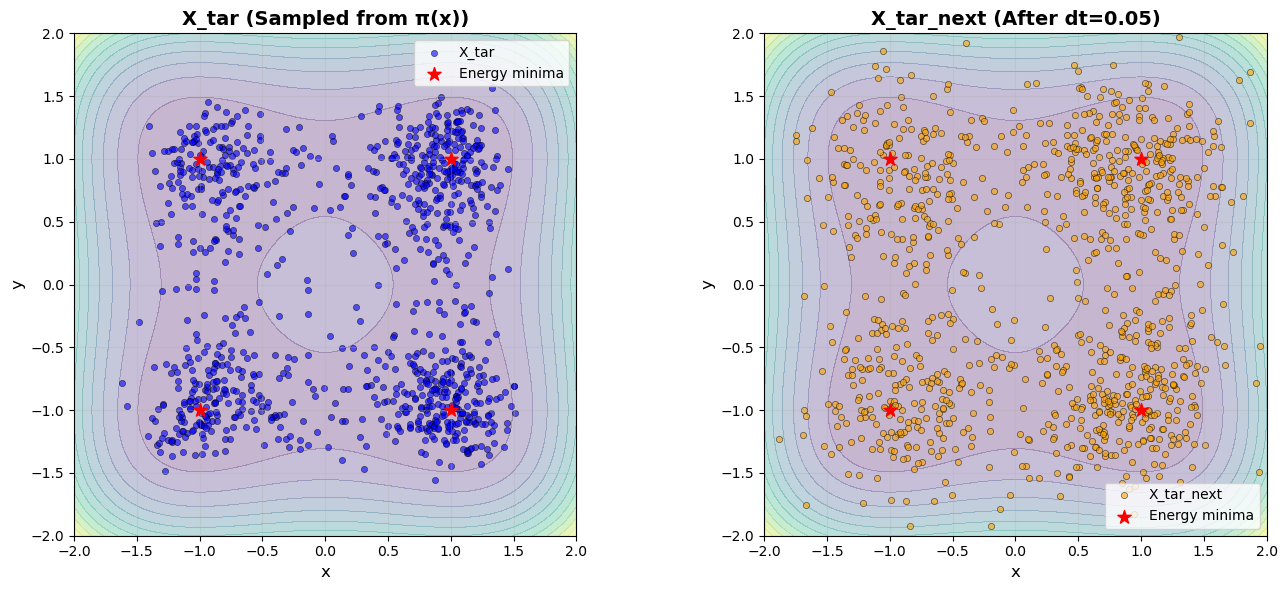


Data generation complete!
Training data pairs: 1000


In [7]:
# ============================================================
# Visualize X_tar and X_tar_next
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ========== Subplot 1: X_tar (current state) ==========
ax1 = axes[0]
# Plot potential contour as background
contourf1 = ax1.contourf(X_grid, Y_grid, V_grid, levels=15, cmap='viridis', alpha=0.3)
ax1.scatter(X_tar[:, 0], X_tar[:, 1], c='blue', s=20, alpha=0.6, label='X_tar', edgecolors='k', linewidth=0.5)
ax1.scatter([-1, -1, 1, 1], [-1, 1, -1, 1], color='red', s=100, marker='*', label='Energy minima', zorder=10)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_title('X_tar (Sampled from π(x))', fontsize=14, fontweight='bold')
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_aspect('equal')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ========== Subplot 2: X_tar_next (evolved state) ==========
ax2 = axes[1]
contourf2 = ax2.contourf(X_grid, Y_grid, V_grid, levels=15, cmap='viridis', alpha=0.3)
ax2.scatter(X_tar_next[:, 0], X_tar_next[:, 1], c='orange', s=20, alpha=0.6, label='X_tar_next', edgecolors='k', linewidth=0.5)
ax2.scatter([-1, -1, 1, 1], [-1, 1, -1, 1], color='red', s=100, marker='*', label='Energy minima', zorder=10)
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('y', fontsize=12)
ax2.set_title(f'X_tar_next (After dt={dt})', fontsize=14, fontweight='bold')
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_aspect('equal')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Data generation complete!")
print("="*60)
print(f"Training data pairs: {X_tar.shape[0]}")
print("="*60)

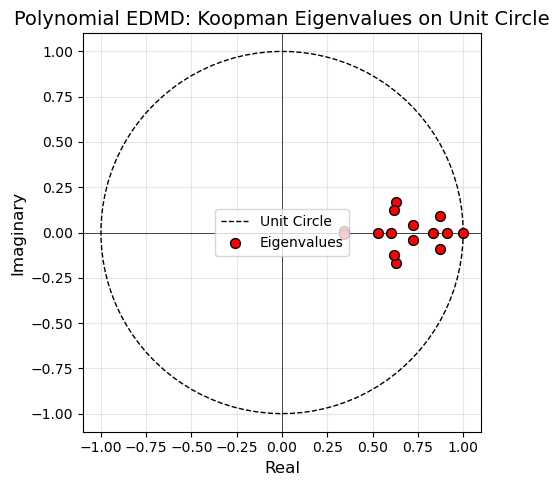

Number of eigenvalues: 15
Max magnitude: 1.0000
Eigenvalues outside unit circle: 0

Eigenvalues (Real part, sorted from large to small):
  1. +1.000000
  2. +0.911199
  3. +0.873329
  4. +0.873329
  5. +0.834983
  6. +0.720461
  7. +0.720461
  8. +0.629851
  9. +0.629851
 10. +0.620033
 11. +0.620033
 12. +0.603786
 13. +0.531048
 14. +0.340602
 15. +0.340602


In [8]:
# ============================================================
# Polynomial EDMD: Extended Dynamic Mode Decomposition
# ============================================================

# Preconditions
if 'X_tar' not in globals() or 'X_tar_next' not in globals():
    raise RuntimeError('X_tar and X_tar_next must be computed before running EDMD (polynomial).')

n = X_tar.shape[0]

# Step 1: Build polynomial basis functions
degree = 4

def monomial_exponents_2d(deg: int):
    exps = []
    for total in range(deg + 1):
        for i in range(total + 1):
            exps.append((i, total - i))
    return exps

exps = monomial_exponents_2d(degree)
m_dict = len(exps)

# Optional feature scaling for numerical stability
Z_all = np.vstack([X_tar, X_tar_next])
scale = 1.0  # No scaling for this example
X0 = X_tar / scale
Y0 = X_tar_next / scale

# Feature map Φ(X)
def phi_poly(X: np.ndarray) -> np.ndarray:
    N = X.shape[0]
    Phi = np.empty((N, m_dict), dtype=float)
    x = X[:, 0]
    y = X[:, 1]
    for k, (i, j) in enumerate(exps):
        if i == 0 and j == 0:
            Phi[:, k] = 1.0
        elif i == 0:
            Phi[:, k] = y ** j
        elif j == 0:
            Phi[:, k] = x ** i
        else:
            Phi[:, k] = (x ** i) * (y ** j)
    return Phi

Phi = phi_poly(X0)
Phi_next = phi_poly(Y0)
N = Phi.shape[0]

# Step 2: Build EDMD matrices
G_edmd = (Phi.T @ Phi) / N
A_edmd = (Phi.T @ Phi_next) / N

# Step 3: Compute Koopman operator
reg = 1e-10
I = np.eye(G_edmd.shape[0])
K_edmd = np.linalg.solve(G_edmd + reg * I, A_edmd)

# Step 4: Compute eigenvalues
eigenvalues_edmd = np.linalg.eigvals(K_edmd)

# Step 5: Construct generator eigenvalues and inverse weights
# Extract real part of eigenvalues (ignore imaginary part)
lambda_ns_edmd = eigenvalues_edmd.real

# Construct generator eigenvalues: λ_gen = (λ_K - 1) / dt
lambda_gen_edmd = (lambda_ns_edmd - 1.0) / dt

# Build inverse generator weights (for LAWGD)
tol_edmd = 1e-6
lambda_ns_inv_edmd = np.zeros_like(lambda_ns_edmd)
mask_edmd = lambda_ns_edmd >= tol_edmd
lambda_ns_inv_edmd[mask_edmd] = 1.0 / (lambda_ns_edmd[mask_edmd] + 0.001)

# Store results for LAWGD
eigvals_K_edmd = lambda_ns_edmd.copy()
lambda_gen_full_edmd = lambda_gen_edmd.copy()

# ============================================================
# Visualization: Eigenvalues on Unit Circle
# ============================================================

fig, ax = plt.subplots(figsize=(5, 5))

# Plot unit circle
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1, label='Unit Circle')

# Plot eigenvalues
ax.scatter(eigenvalues_edmd.real, eigenvalues_edmd.imag, c='red', s=50, marker='o', 
           edgecolors='black', linewidths=1, label='Eigenvalues', zorder=3)

# Set equal aspect ratio and labels
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_xlabel('Real', fontsize=12)
ax.set_ylabel('Imaginary', fontsize=12)
ax.set_title('Polynomial EDMD: Koopman Eigenvalues on Unit Circle', fontsize=14)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print(f"Number of eigenvalues: {len(eigenvalues_edmd)}")
print(f"Max magnitude: {np.max(np.abs(eigenvalues_edmd)):.4f}")
print(f"Eigenvalues outside unit circle: {np.sum(np.abs(eigenvalues_edmd) > 1)}")

# Sort eigenvalues by real part (descending order)
sorted_real_edmd = np.sort(eigenvalues_edmd.real)[::-1]

print("\n" + "="*50)
print("Eigenvalues (Real part, sorted from large to small):")
print("="*50)
for i, real_part in enumerate(sorted_real_edmd):
    print(f"{i+1:3d}. {real_part:+.6f}")

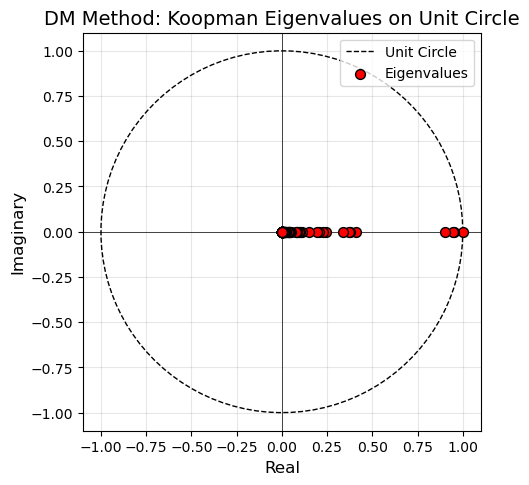

Number of eigenvalues: 1000
Max magnitude: 1.0014
Eigenvalues outside unit circle: 1

Eigenvalues (Real part, sorted from large to small):
  1. +1.001428
  2. +0.951636
  3. +0.947431
  4. +0.901624
  5. +0.409910
  6. +0.375254
  7. +0.368787
  8. +0.335269
  9. +0.242259
 10. +0.227039
 11. +0.205031
 12. +0.193010
 13. +0.150112
 14. +0.109393
 15. +0.101026
 16. +0.092824
 17. +0.086226
 18. +0.083495
 19. +0.080285
 20. +0.051276
 21. +0.046832
 22. +0.040985
 23. +0.038924
 24. +0.037728
 25. +0.032900
 26. +0.031635
 27. +0.022011
 28. +0.021174
 29. +0.017994
 30. +0.015818
 31. +0.014880
 32. +0.013708
 33. +0.012049
 34. +0.010547
 35. +0.009477
 36. +0.009054
 37. +0.007492
 38. +0.006510
 39. +0.005682
 40. +0.005088
 41. +0.004939
 42. +0.004318
 43. +0.003763
 44. +0.003524
 45. +0.002847
 46. +0.002718
 47. +0.002422
 48. +0.002051
 49. +0.001802
 50. +0.001593
 51. +0.001537
 52. +0.001279
 53. +0.001189
 54. +0.001078
 55. +0.000938
 56. +0.000791
 57. +0.000757
 58. +

In [9]:
# ============================================================
# DM Method: Diffusion Maps for Langevin Generator Construction
# ============================================================

# Preconditions
if 'X_tar' not in globals() or 'X_tar_next' not in globals():
    raise RuntimeError('X_tar and X_tar_next must be computed before running DM method.')

n = X_tar.shape[0]

# Step 1: Build Gaussian kernel
sq_tar = np.sum(X_tar ** 2, axis=1)
H = sq_tar[:, None] + sq_tar[None, :] - 2 * (X_tar @ X_tar.T)
epsilon = 0.5 * np.median(H) / np.log(n + 1)

def ker(X):
    """Gaussian kernel k(x,y) = exp(-||x-y||²/(2ε))"""
    sq = np.sum(X ** 2, axis=1)
    return np.exp(-(sq[:, None] + sq[None, :] - 2 * (X @ X.T)) / (2 * epsilon))

data_kernel = ker(X_tar)

# Step 2: Anisotropic normalization
p_x = np.sqrt(np.sum(data_kernel, axis=1))
p_y = p_x.copy()
data_kernel_norm = data_kernel / p_x[:, None] / p_y[None, :]
D_y = np.sum(data_kernel_norm, axis=0)

# Step 3: Random-walk symmetric normalization
rw_kernel = 0.5 * (data_kernel_norm / D_y + data_kernel_norm / D_y[:, None])

# Step 4: SVD to get spectrum
phi, s, _ = svd(rw_kernel)
lambda_ns = s  # Singular values (eigenvalues of symmetric matrix)

# Step 5: Construct generator eigenvalues
lambda_gen_dm = (lambda_ns - 1.0) / dt

# Step 6: Build inverse generator weights (for LAWGD)
tol = 1e-6
lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = epsilon / (lambda_ns[mask] + 0.001)

# Store results for LAWGD
eigvals_K_dm = lambda_ns.copy()
eigvecs_K_dm = phi.copy()
lambda_gen_full = lambda_gen_dm.copy()

# ============================================================
# Visualization: Eigenvalues on Unit Circle
# ============================================================

fig, ax = plt.subplots(figsize=(5, 5))

# Plot unit circle
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1, label='Unit Circle')

# Plot eigenvalues
ax.scatter(eigvals_K_dm.real, eigvals_K_dm.imag, c='red', s=50, marker='o', 
           edgecolors='black', linewidths=1, label='Eigenvalues', zorder=3)

# Set equal aspect ratio and labels
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_xlabel('Real', fontsize=12)
ax.set_ylabel('Imaginary', fontsize=12)
ax.set_title('DM Method: Koopman Eigenvalues on Unit Circle', fontsize=14)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print(f"Number of eigenvalues: {len(eigvals_K_dm)}")
print(f"Max magnitude: {np.max(np.abs(eigvals_K_dm)):.4f}")
print(f"Eigenvalues outside unit circle: {np.sum(np.abs(eigvals_K_dm) > 1)}")

# Sort eigenvalues by real part (descending order)
sorted_real_dm = np.sort(eigvals_K_dm.real)[::-1]

print("\n" + "="*50)
print("Eigenvalues (Real part, sorted from large to small):")
print("="*50)
for i, real_part in enumerate(sorted_real_dm):
    print(f"{i+1:3d}. {real_part:+.6f}")


Step 1: Generate initial particles outside wells...
MCMC sampling complete:
  - Total iterations: 12000
  - Burnin: 2000
  - Thinning: 20
  - Acceptance rate: 57.92%
  - Final samples: 500
Initial particles sampled: 500
Particles outside wells (r > 0.4): 225
Particles removed (inside wells): 275

Step 2: Preparing LAWGD with DM Koopman spectrum...

  Mode selection strategy: use all valid modes
    - Total eigenvalues: 1000
    - Skipping first 1 eigenvalues (constant modes)
    - Eigenvalue threshold: λ > 0.01 (exclude near-zero)
    - Skipped due to threshold: 966
    - **Using 33 valid modes** (modes 2 to 34)

  Selected eigenvalues for LAWGD:
    Mode 2: λ = 0.951636, λ_gen = -0.97
    Mode 3: λ = 0.947431, λ_gen = -1.05
    Mode 4: λ = 0.901624, λ_gen = -1.97
    Mode 5: λ = 0.409910, λ_gen = -11.80
    Mode 6: λ = 0.375254, λ_gen = -12.49
    Mode 7: λ = 0.368787, λ_gen = -12.62
    Mode 8: λ = 0.335269, λ_gen = -13.29
    Mode 9: λ = 0.242259, λ_gen = -15.15
    Mode 10: λ = 0.2

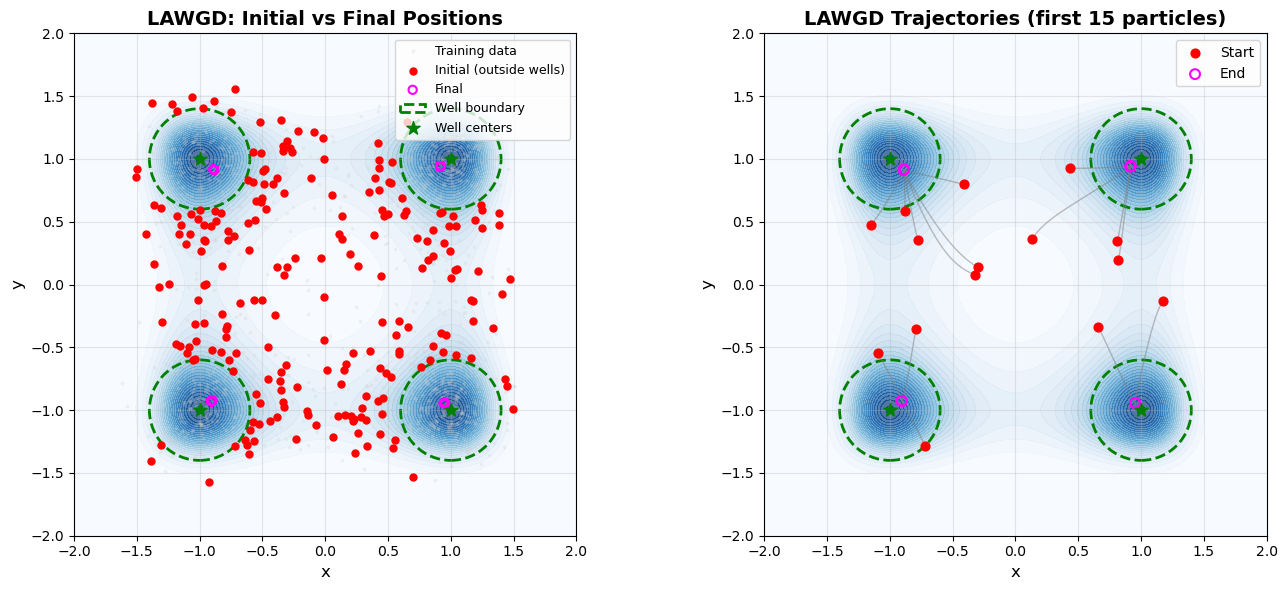

In [10]:
# ============================================================
# LAWGD: Langevin-Adjusted Wasserstein Gradient Descent
# ============================================================

from matplotlib.patches import Circle

print("="*60)
print("Step 1: Generate initial particles outside wells...")
print("="*60)

# Step 1: Generate 500 points from stationary distribution
n_init_particles = 500
X_init_all = sample_from_stationary(potential, n_samples=n_init_particles, burnin=2000, thin=20)

# Step 2: Remove points within radius of well centers (±1, ±1)
well_centers = np.array([[-1.0, -1.0], [-1.0, 1.0], [1.0, -1.0], [1.0, 1.0]])
well_radius = 0.4

# Compute distances to all four wells
dist_to_wells = np.array([np.linalg.norm(X_init_all - center, axis=1) for center in well_centers])
min_dist_to_wells = np.min(dist_to_wells, axis=0)

# Keep only points outside both wells
mask_outside = min_dist_to_wells > well_radius
X_lawgd_init = X_init_all[mask_outside]

print(f"Initial particles sampled: {n_init_particles}")
print(f"Particles outside wells (r > {well_radius}): {X_lawgd_init.shape[0]}")
print(f"Particles removed (inside wells): {n_init_particles - X_lawgd_init.shape[0]}")

# Step 2: Prepare LAWGD using DM-based Koopman spectrum
print(f"\n{'='*60}")
print("Step 2: Preparing LAWGD with DM Koopman spectrum...")
print(f"{'='*60}")

# Use DM method results (computed in previous cell)
eigvals_K = eigvals_K_dm.copy()
eigvecs_K = eigvecs_K_dm.copy()
lambda_gen = lambda_gen_full.copy()

# Mode selection strategy: use all valid modes
n_skip = 1  # Skip first 1 eigenvalues (constant modes)
eig_threshold = 0.01  # Threshold for valid eigenvalues (exclude near-zero eigenvalues)

# Find valid eigenvalues: skip first n_skip, and keep those > threshold
eigvals_after_skip = eigvals_K[n_skip:]
valid_mask = eigvals_after_skip.real > eig_threshold
n_valid = np.sum(valid_mask)

# Use ALL valid modes
k_modes = n_valid
mode_start = n_skip
mode_end = mode_start + k_modes

print(f"\n  Mode selection strategy: use all valid modes")
print(f"    - Total eigenvalues: {len(eigvals_K)}")
print(f"    - Skipping first {n_skip} eigenvalues (constant modes)")
print(f"    - Eigenvalue threshold: λ > {eig_threshold} (exclude near-zero)")
print(f"    - Skipped due to threshold: {len(eigvals_K) - n_skip - k_modes}")
print(f"    - **Using {k_modes} valid modes** (modes {mode_start+1} to {mode_end})")
print(f"\n  Selected eigenvalues for LAWGD:")
for i in range(mode_start, mode_end):
    print(f"    Mode {i+1}: λ = {eigvals_K[i].real:.6f}, λ_gen = {lambda_gen[i].real:.2f}")

# Build inverse generator weights for selected modes
lambda_gen_selected = lambda_gen[mode_start:mode_end]
tol_gen = 1e-6
lambda_gen_inv_selected = np.zeros(k_modes, dtype=complex)
mask_nonzero = np.abs(lambda_gen_selected) > tol_gen
lambda_gen_inv_selected[mask_nonzero] = 1.0 / lambda_gen_selected[mask_nonzero]

print(f"  Generator eigenvalue range: [{lambda_gen_selected.real.min():.2f}, {lambda_gen_selected.real.max():.2f}]")

# Step 4: Helper functions for kernel evaluation and gradient
def evaluate_kernel_at_points(X_query, X_data):
    """
    Evaluate normalized kernel k(x_query, x_data) for all pairs
    Returns: (n_query, n_data) kernel matrix
    """
    sq_query = np.sum(X_query ** 2, axis=1)
    sq_data = np.sum(X_data ** 2, axis=1)
    H = sq_query[:, None] + sq_data[None, :] - 2 * (X_query @ X_data.T)
    K_raw = np.exp(-H / (2 * epsilon))
    
    # Apply anisotropic normalization (using p_x from training data)
    # For query points, estimate density using kernel with training data
    p_query = np.sqrt(np.sum(K_raw, axis=1))
    K_norm = K_raw / p_query[:, None] / p_x[None, :]
    
    # Apply random-walk normalization (using D_y from training)
    # K_rw[i,j] = 0.5 * (K_norm[i,j] / D_y[j] + K_norm[j,i] / D_y[i])
    # Since K_norm is (n_query, n_data) and not symmetric, we simplify:
    K_rw = K_norm / D_y[None, :]  # Divide each column by D_y
    
    return K_rw

def compute_kernel_gradient(X_query, X_data):
    """
    Compute gradient of kernel ∇_x k(x, y) w.r.t. x (query points)
    Returns: (n_query, n_data, 2) array where [:, :, d] is ∂k/∂x_d
    """
    n_query = X_query.shape[0]
    n_data = X_data.shape[0]
    
    # Compute pairwise differences: X_query - X_data
    # Shape: (n_query, n_data, 2)
    diff = X_query[:, None, :] - X_data[None, :, :]  # Broadcasting
    
    # Compute base kernel
    sq_query = np.sum(X_query ** 2, axis=1)
    sq_data = np.sum(X_data ** 2, axis=1)
    H = sq_query[:, None] + sq_data[None, :] - 2 * (X_query @ X_data.T)
    K_raw = np.exp(-H / (2 * epsilon))
    
    # Gradient of Gaussian kernel: ∂k/∂x = -k(x,y) * (x-y) / ε
    # Shape: (n_query, n_data, 2)
    grad_K_raw = -K_raw[:, :, None] * diff / epsilon
    
    # For simplicity, apply normalization to gradient (approximate)
    # This is a simplified version; full gradient would include normalization terms
    p_query = np.sqrt(np.sum(K_raw, axis=1, keepdims=True))
    grad_K_norm = grad_K_raw / p_query[:, :, None] / p_x[None, :, None]
    
    return grad_K_norm

# Step 5: LAWGD iteration with DM kernel
n_particles = X_lawgd_init.shape[0]
n_iter_lawgd = 1000
h_lawgd = 1  # Step size

X_lawgd_traj = np.zeros((n_particles, 2, n_iter_lawgd))
X_lawgd_traj[:, :, 0] = X_lawgd_init.copy()

print(f"\n{'='*60}")
print("Step 3: Running LAWGD iterations (DM kernel-based)...")
print(f"{'='*60}")
print(f"Particles: {n_particles}")
print(f"Iterations: {n_iter_lawgd}")
print(f"Step size: {h_lawgd}")
print(f"Active modes: {k_modes}")

for t in range(n_iter_lawgd - 1):
    X_curr = X_lawgd_traj[:, :, t]
    
    # Evaluate kernel between current particles and training data
    K_curr = evaluate_kernel_at_points(X_curr, X_tar)  # (n_particles, n_data)
    
    # Project onto eigenmodes: c = Φ^T @ K(x, X_tar)
    # eigvecs_K has shape (n_data, n_data), we use selected modes
    eigvecs_selected = eigvecs_K[:, mode_start:mode_end]  # (n_data, k_modes)
    c = eigvecs_selected.T @ K_curr.T  # (k_modes, n_particles)
    
    # Apply inverse generator: c_inv = Λ_gen^{-1} @ c
    c_inv = lambda_gen_inv_selected[:, None] * c  # (k_modes, n_particles)
    
    # Project back to data space: f = Φ @ c_inv
    f_inv = eigvecs_selected @ c_inv  # (n_data, n_particles)
    
    # Compute gradient using kernel gradient
    grad_K = compute_kernel_gradient(X_curr, X_tar)  # (n_particles, n_data, 2)
    
    # Gradient update: ∇_x f = Σ_i f_inv[i] * ∇_x k(x, x_i)
    grad_update = np.zeros((n_particles, 2))
    for d_idx in range(2):
        grad_update[:, d_idx] = np.sum(
            grad_K[:, :, d_idx] * f_inv.T.real,  # Use real part
            axis=1
        )
    
    # Gradient descent step
    X_lawgd_traj[:, :, t+1] = X_curr - h_lawgd * grad_update
    
    if (t+1) % 100 == 0 or t == 0:
        print(f"  Iteration {t+1}/{n_iter_lawgd-1}")

print("LAWGD iteration complete!")

# Step 6: Compute final metrics
dist_final_to_wells = np.array([np.linalg.norm(X_lawgd_traj[:, :, -1] - center, axis=1) for center in well_centers])
min_dist_final = np.min(dist_final_to_wells, axis=0)
in_well_final = min_dist_final <= well_radius

print(f"\n{'='*60}")
print("LAWGD Results:")
print(f"{'='*60}")
print(f"Initial particles (outside wells): {n_particles}")
print(f"Final particles inside wells: {np.sum(in_well_final)} ({100*np.sum(in_well_final)/n_particles:.1f}%)")
print(f"Final particles still outside: {n_particles - np.sum(in_well_final)} ({100*(n_particles - np.sum(in_well_final))/n_particles:.1f}%)")
print(f"{'='*60}")

# Step 7: Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Initial vs Final positions
ax1 = axes[0]
ax1.contourf(X_grid, Y_grid, density_grid, levels=30, cmap='Blues', alpha=0.7)
ax1.scatter(X_tar[:, 0], X_tar[:, 1], s=3, c='lightgray', alpha=0.2, label='Training data')
ax1.scatter(X_lawgd_traj[:, 0, 0], X_lawgd_traj[:, 1, 0], 
           s=25, c='red', marker='o', label='Initial (outside wells)', zorder=5)
ax1.scatter(X_lawgd_traj[:, 0, -1], X_lawgd_traj[:, 1, -1], 
           s=35, facecolors='none', edgecolors='magenta', linewidth=1.5, 
           label='Final', zorder=5)

# Draw well boundaries
for idx, center in enumerate(well_centers):
    circle = Circle(center, well_radius, fill=False, edgecolor='green', 
                   linewidth=2, linestyle='--', 
                   label='Well boundary' if idx == 0 else '')
    ax1.add_patch(circle)

ax1.scatter(well_centers[:, 0], well_centers[:, 1], s=100, c='green', 
           marker='*', label='Well centers', zorder=10)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_title('LAWGD: Initial vs Final Positions', fontsize=14, fontweight='bold')
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_aspect('equal')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# Right plot: Trajectories (show first 15 particles)
ax2 = axes[1]
ax2.contourf(X_grid, Y_grid, density_grid, levels=30, cmap='Blues', alpha=0.7)

n_show_traj = min(15, n_particles)
for i in range(n_show_traj):
    ax2.plot(X_lawgd_traj[i, 0, :], X_lawgd_traj[i, 1, :], 
            alpha=0.5, linewidth=1, color='gray')

ax2.scatter(X_lawgd_traj[:n_show_traj, 0, 0], X_lawgd_traj[:n_show_traj, 1, 0], 
           s=40, c='red', marker='o', zorder=5, label='Start')
ax2.scatter(X_lawgd_traj[:n_show_traj, 0, -1], X_lawgd_traj[:n_show_traj, 1, -1], 
           s=50, facecolors='none', edgecolors='magenta', 
           linewidth=1.5, zorder=5, label='End')

for idx, center in enumerate(well_centers):
    circle = Circle(center, well_radius, fill=False, edgecolor='green', 
                   linewidth=2, linestyle='--')
    ax2.add_patch(circle)

ax2.scatter(well_centers[:, 0], well_centers[:, 1], s=100, c='green', 
           marker='*', zorder=10)
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('y', fontsize=12)
ax2.set_title(f'LAWGD Trajectories (first {n_show_traj} particles)', 
             fontsize=14, fontweight='bold')
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_aspect('equal')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()